# Purpose


**2023-04-17**:<br>
<br> In this notebook we'll try an end-to-end process to get user<>subreddit table & training datay for a single campaign.


**DONE (previous steps)**
- Pull data:
    - User Time on Subreddit (save to local now, GCS in prod)
    - Get subreddit-level embeddings (save to local, GCS in prod)
- Reshape to get user-embeddings
    - For each ToSub file, get weighted embeddings for a user
        - Save user-level (weighted) embeddings to file
- Calculate ANN distance to input subreddit(s)
    - Create an index with ANNOY: per COUNTRY + subreddit
        - This way we ensure a minimum # of users per country
    - Load subreddit-embedding file
    - For each input target subreddit, get the ANN users
        - Try nearest 3 million users
    - Save raw ANN file

**This notebook:** <br>
(Quick version of these steps. We'll re-write when scaling up to multiple campaigns b/c the data will prob change)
- Load training data & labels for modeling (click/no click)
- Split into basic train/test fold
- Train base models on labeled data
    - Quick evaluation of model
- Run inference on all users & get proba() for all users & user<>sub combination
    - Save proba raw file
- Rank users by proba
    - Compare which users our model would say likely to click, but didn't even receive the PN
- Reshape user<>subreddit proba PN for bigQuery
    - Pick top 1 million users per subreddit


**TODO later / out of scope**
- Split training file into k-fold validation or train/test
- Train base models (do it a separate notebook)
- [later/tbd] Reshape ANN table & upload to BQ table
    - Reshape ANN file for BigQuery format
    - Upload ANN file to BQ for table creation




# Imports & Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import gc
import logging
from logging import info
import os
from pathlib import Path
import json

import polars as pl
import numpy as np
import pandas as pd
import plotly
import seaborn as sns

from tqdm.auto import tqdm
import dask
import mlflow

import subclu
from subclu.eda.aggregates import compare_raw_v_weighted_language
from subclu.utils import set_working_directory, get_project_subfolder
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)
from subclu.utils.mlflow_logger import MlflowLogger
from subclu.utils.hydra_config_loader import LoadHydraConfig
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl, 
    get_color_dict, base_colors_for_manual_labels,
    check_colors_used,
)
from subclu.data.data_loaders import LoadPosts, LoadSubreddits, create_sub_level_aggregates


# ===
# imports specific to this notebook
from typing import Tuple, Union

from subclu.models.nn_annoy import AnnoyIndex
from subclu.utils.eda import get_venn_sets2

from matplotlib_venn import venn2_unweighted

from google.cloud import bigquery
from subclu.pn_models import get_data


client = bigquery.Client()

print_lib_versions([bigquery, np, pd, pl, plotly, mlflow, subclu])

python		v 3.7.10
===
google.cloud.bigquery	v: 2.13.1
numpy		v: 1.19.5
pandas		v: 1.2.4
polars		v: 0.17.1
plotly		v: 5.11.0
mlflow		v: 1.16.0
subclu		v: 0.6.1


In [3]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Define local path for this model outputs

In [4]:
manual_model_timestamp = datetime.utcnow().strftime('%Y-%m-%d_%H%M%S')
path_this_model = get_project_subfolder(
    f"data/models/pn_model/pn_manual_test_{manual_model_timestamp}"
)
Path.mkdir(path_this_model, parents=True, exist_ok=True)
print(path_this_model)

/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-04-24_151916


In [5]:
path_ann_df = Path("/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-04-19_172950")
f_ann_df = str(path_ann_df / "df_ann_distance_to_target-10533999_5.parquet")

In [6]:
!ls $path_ann_df

df_ann_distance_to_target-10533999_5.parquet
df_ann_distance_to_target-10533999_6.parquet
df_subreddit_embeddings_wide-236115_102.parquet
df_user_embedding-2023-04-19_1841-10533999_by_101.parquet


# Define key inputs
Use these throughout the process to filter/target specific subreddits, geos, & users

In [7]:
l_target_subreddits = ['de']

# We would want to add an automated way to pick these ANN subs, but look them up manually for now
l_target_ann_subreddits = ['fragreddit', 'ich_iel']

l_target_geos = ['DE']

# Load & reshape data

## Load training data from BQ

Label info:
- send, receive, click [Click is the target, but we need sends & receives so that we can select only users who received or clicked]

Selected features v0:
- TODO: num of subreddits in ToS calculation
- views, consumes, etc. in target subreddit
- User latest country
- user<>subreddit distances (currently in a local file, not in BQ)

features to add for v1:
- target subreddit percentage visits from different geos (wide version of `community_score` table)
- target subreddit primary language
- user primary language(s)

#### Features to add maybe way later(?)
`Subscription` tables expire after 90 days... (sigh)
<br>So we'll have imperfect data for training models before 2023-02
<br>Maybe we should just exclude it for historical campaigns and only add it going forward?


**NOTE / TODO(djb)**
- For this notebook I'll only train on user who RECEIVED the PN
- But in the future we might want to model whether someone will even receive the PN (saves us from wasting PNs on users not likely to be active... unless the goal is to re-activate dormant users)

In [ ]:
TODO

In [8]:
%%time
%%bigquery df_train_raw --project data-science-prod-218515 

-- Select trainig data AND users to train PN model
DECLARE PT_FEATURES DATE DEFAULT "2022-12-01";


WITH subreddit_per_user_count AS (
    SELECT
        tos.user_id
        , COUNT(DISTINCT subreddit_id) AS tos_sub_count
    FROM `reddit-employee-datasets.david_bermejo.pn_test_users_de_campaign_tos_30_pct_20230418` AS tos
    GROUP BY 1
)
, post_consumes_agg AS (
    SELECT
        user_id
        , SUM(num_post_consumes) AS num_post_consumes
        , SUM(num_post_consumes_home) AS num_post_consumes_home
        , SUM(num_post_consumes_community) AS num_post_consumes_community
        , SUM(num_post_consumes_post_detail) AS num_post_consumes_post_detail
        , SUM(IF(app_name = 'ios', num_post_consumes, 0)) AS num_post_consumes_ios
        , SUM(IF(app_name = 'android', num_post_consumes, 0)) AS num_post_consumes_android
        , SUM(num_post_consumes_nsfw) AS num_post_consumes_nsfw
        , SAFE_DIVIDE(SUM(num_post_consumes_nsfw), SUM(num_post_consumes)) AS pct_post_consumes_nsfw
        -- , SUM(num_post_consumes_sfw) AS num_post_consumes_sfw
    FROM `data-prod-165221.video.post_consumes_30d_agg`
    WHERE DATE(pt) = PT_FEATURES
    GROUP BY 1
)
, core_train_info AS (
    SELECT
        -- Need to fill cases where user_id is missing from new selection criteria
        COALESCE(act.user_id, f.user_id) AS user_id
        , COALESCE(act.target_subreddit, f.subreddit_name) AS subreddit_name
        , COALESCE(act.send, 0) AS send
        , COALESCE(act.receive, 0) AS receive
        , COALESCE(act.click, 0) AS click
        
        -- , f.subreddit_id
        -- , f.subreddit_name AS view_sub_name
        , f.* EXCEPT(pt, pt_window_start, user_id, subreddit_name, subreddit_id)

    FROM (
        SELECT *
        FROM `reddit-employee-datasets.david_bermejo.pn_test_users_de_campaign_20230418`
        WHERE subreddit_name = 'de'
    ) AS f
        FULL OUTER JOIN `reddit-employee-datasets.david_bermejo.pn_training_data_test` AS act
            ON f.user_id = act.user_id
)

SELECT
    -- Need to fill cases where user_id is missing from new selection criteria
    ct.user_id
    , ct.subreddit_name
    , ct.send
    , ct.receive
    , ct.click
    , COALESCE(tos.tos_sub_count, 0) AS tos_sub_count
    , COALESCE(sv.feature_value, 0) AS screen_view_count_14d
    , cl.legacy_user_cohort
    , co.* EXCEPT(user_id)
    , ct.* EXCEPT(user_id, subreddit_name, send, receive, click)

FROM core_train_info AS ct
    -- Get count of subs in ToS
    LEFT JOIN subreddit_per_user_count AS tos
        ON ct.user_id = tos.user_id
    -- Get view counts (all subreddits)
    LEFT JOIN (
        SELECT entity_id, feature_value
        FROM `data-prod-165221.user_feature_platform.screen_views_count_over_14_days_v1` 
        WHERE DATE(pt) = PT_FEATURES
    ) AS sv
        ON ct.user_id = sv.entity_id
    -- USER cohort, Legacy
    LEFT JOIN (
        SELECT user_id, legacy_user_cohort
        FROM `data-prod-165221.attributes_platform.user_rolling_legacy_user_cohorts` 
        WHERE DATE(pt) = PT_FEATURES
    ) AS cl
        ON ct.user_id = cl.user_id
    -- USER consumes
    LEFT JOIN post_consumes_agg AS co
        ON ct.user_id = co.user_id

WHERE ct.receive = 1

ORDER BY click DESC, tos_sub_count DESC
;

Downloading: 100%|██████████| 253584/253584 [00:01<00:00, 158082.00rows/s]

CPU times: user 3.11 s, sys: 597 ms, total: 3.71 s
Wall time: 4min 54s


In [9]:
df_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253584 entries, 0 to 253583
Data columns (total 25 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   user_id                              253584 non-null  object 
 1   subreddit_name                       253584 non-null  object 
 2   send                                 253584 non-null  int64  
 3   receive                              253584 non-null  int64  
 4   click                                253584 non-null  int64  
 5   tos_sub_count                        253584 non-null  int64  
 6   screen_view_count_14d                253584 non-null  int64  
 7   legacy_user_cohort                   170906 non-null  object 
 8   num_post_consumes                    247442 non-null  float64
 9   num_post_consumes_home               247442 non-null  float64
 10  num_post_consumes_community          247442 non-null  float64
 11  num_post_cons

In [10]:
counts_describe(df_train_raw[['user_id', 'subreddit_name',  'click', 'subscribed']])

,dtype,count,unique,unique-percent,null-count,null-percent
user_id,object,"253,584","253,583",100.00%,0,0.00%
subreddit_name,object,"253,584",1,0.00%,0,0.00%
click,int64,"253,584",2,0.00%,0,0.00%
subscribed,float64,"181,406",1,0.00%,"72,178",28.46%


Unclear where these duplicates came from, but for now we'll remove them.

TODO(djb): Will go back to debug user-generation later

In [11]:
(
    df_train_raw[df_train_raw.duplicated(subset='user_id', keep=False)]
    .sort_values(by=['user_id'])
)

,user_id,subreddit_name,send,receive,click,tos_sub_count,screen_view_count_14d,legacy_user_cohort,num_post_consumes,num_post_consumes_home,num_post_consumes_community,num_post_consumes_post_detail,num_post_consumes_ios,num_post_consumes_android,num_post_consumes_nsfw,pct_post_consumes_nsfw,geo_country_code,subscribed,user_in_actual_but_missing_from_new,view_and_consume_unique_count,consume_unique_count,view_count,consume_count,consume_ios_count,consume_android_count
56448,t2_6yxrzyy,de,1,1,0,121,21,core,8806.0,1351.0,3198.0,0.0,8806.0,0.0,185.0,0.021008,DE,0.0,0.0,744.0,742.0,380.0,2216.0,2216.0,0.0
56449,t2_6yxrzyy,de,1,1,0,121,21,core,8806.0,1351.0,3198.0,0.0,8806.0,0.0,185.0,0.021008,DE,0.0,0.0,1.0,1.0,0.0,2.0,2.0,0.0


In [12]:
%%time

df_train_raw = df_train_raw.drop_duplicates(subset=['user_id'], keep=False)
df_train_raw.shape

CPU times: user 85 ms, sys: 15.5 ms, total: 101 ms
Wall time: 99.6 ms


(253582, 25)

In [13]:
counts_describe(df_train_raw[['user_id', 'subreddit_name', 'click', 'subscribed']])

,dtype,count,unique,unique-percent,null-count,null-percent
user_id,object,"253,582","253,582",100.00%,0,0.00%
subreddit_name,object,"253,582",1,0.00%,0,0.00%
click,int64,"253,582",2,0.00%,0,0.00%
subscribed,float64,"181,404",1,0.00%,"72,178",28.46%


In [14]:
assert len(df_train_raw) == df_train_raw['user_id'].nunique()

In [15]:
df_train_raw.head()

,user_id,subreddit_name,send,receive,click,tos_sub_count,screen_view_count_14d,legacy_user_cohort,num_post_consumes,num_post_consumes_home,num_post_consumes_community,num_post_consumes_post_detail,num_post_consumes_ios,num_post_consumes_android,num_post_consumes_nsfw,pct_post_consumes_nsfw,geo_country_code,subscribed,user_in_actual_but_missing_from_new,view_and_consume_unique_count,consume_unique_count,view_count,consume_count,consume_ios_count,consume_android_count
0,t2_9zijedm0,de,1,1,1,1013,21,core,29743.0,2007.0,11541.0,0.0,0.0,29743.0,19575.0,0.658138,DE,0.0,0.0,49.0,46.0,8.0,124.0,0.0,124.0
1,t2_is69c8yu,de,1,1,1,954,21,core,21346.0,4375.0,3640.0,0.0,0.0,21346.0,17080.0,0.800150,DE,0.0,0.0,1.0,1.0,2.0,6.0,0.0,6.0
2,t2_md0rajcx,de,1,1,1,918,21,core,32850.0,18765.0,3873.0,0.0,0.0,32850.0,29623.0,0.901766,DE,0.0,0.0,474.0,474.0,72.0,1230.0,0.0,1230.0
3,t2_tahcrp1q,de,1,1,1,829,21,core,15246.0,2466.0,620.0,0.0,0.0,15246.0,13003.0,0.852879,DE,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
4,t2_hqb68gin,de,1,1,1,779,21,core,23333.0,3805.0,7065.0,0.0,0.0,23333.0,18981.0,0.813483,DE,0.0,0.0,20.0,20.0,2.0,50.0,0.0,50.0


## Append user<>subreddit distances 

In [16]:
%%time

df_ann = pl.read_parquet(
    f_ann_df,
    columns=['subreddit_name', 'user_id', 'cosine_similarity'],
)
df_ann.shape

CPU times: user 543 ms, sys: 294 ms, total: 837 ms
Wall time: 1.84 s


(10533999, 3)

In [17]:
(
    df_ann
    .sample(n=int(1e6))
    [['cosine_similarity']]
    .describe()
)

describe,cosine_similarity
str,f64
"""count""",1e6
"""null_count""",0.0
"""mean""",0.454352
"""std""",0.189813
"""min""",-0.026478
"""max""",1.0
"""median""",0.436433


In [19]:
%%time

df_train = (
    df_train_raw
    # .drop(['subreddit_id', 'view_sub_name', ], axis=1)
    [df_train_raw['receive'] == 1]
    .merge(
        df_ann.to_pandas(),
        how='left',
        on=['user_id', 'subreddit_name'],
    ) 
)

df_train.shape

CPU times: user 12.4 s, sys: 1.36 s, total: 13.8 s
Wall time: 13.7 s


(253582, 26)

# Some EDA

In [21]:
counts_describe(df_train)

,dtype,count,unique,unique-percent,null-count,null-percent
user_id,object,"253,582","253,582",100.00%,0,0.00%
subreddit_name,object,"253,582",1,0.00%,0,0.00%
send,int64,"253,582",1,0.00%,0,0.00%
receive,int64,"253,582",1,0.00%,0,0.00%
click,int64,"253,582",2,0.00%,0,0.00%
tos_sub_count,int64,"253,582",816,0.32%,0,0.00%
screen_view_count_14d,int64,"253,582",21,0.01%,0,0.00%
legacy_user_cohort,object,"170,904",4,0.00%,"82,678",32.60%
num_post_consumes,float64,"247,440","29,455",11.90%,"6,142",2.42%
num_post_consumes_home,float64,"247,440","22,590",9.13%,"6,142",2.42%


### All users in original campaign are in new data selection

However, this is only because I forced them into the new selection. It's possible they had views over 1 month ago

In [24]:
value_counts_and_pcts(
    df_train['user_in_actual_but_missing_from_new'].fillna(-1),
    sort_index=True,
    top_n=None,
)

,user_in_actual_but_missing_from_new-count,user_in_actual_but_missing_from_new-percent,user_in_actual_but_missing_from_new-pct_cumulative_sum
0.0,"181,404",71.5%,71.5%
-1.0,"72,178",28.5%,100.0%


### Click (CTR)
Since we're looking only at user that RECEIVED the PN, this CTR should be the same as the one computed in the overall dashboard

In [25]:
value_counts_and_pcts(
    df_train,
    ['click'],
    sort_index=True,
    top_n=None,
)

,count,percent,cumulative_percent
click,,,
1,"13,226",5.2%,5.2%
0,"240,356",94.8%,100.0%


### Clicks by Geo

In [26]:
df_geo_receive_counts = (
    df_train
    .groupby(['geo_country_code'], as_index=False)
    .agg(
        **{'receive_count': ('receive', 'count')}
    )
)

df_geos_over_200 = (
    df_geo_receive_counts
    [df_geo_receive_counts['receive_count'] >= 200]  
)
df_geos_over_200

,geo_country_code,receive_count
4,AT,850
20,CH,633
29,DE,174807
37,ES,245
41,FR,240
42,GB,478
93,NL,564
127,US,653


In [28]:
df_click_by_geo = value_counts_and_pcts(
    df_train,
    ['geo_country_code', 'click'],
    sort_index=True,
    sort_index_ascending=True,
    reset_index=True,
    top_n=None,
    return_df=True
)


style_df_numeric(
    df_click_by_geo
    [(
        (df_click_by_geo['geo_country_code'].isin(df_geos_over_200['geo_country_code'])) |
        (df_click_by_geo['geo_country_code'] == 'null')
    )]
    .drop('cumulative_percent', axis=1)
    .set_index(['geo_country_code', 'click'])
    ,
    l_bar_simple=['count', 'percent'],
)


### Clicks - cohort

In [60]:
value_counts_and_pcts(
    (
        df_train
        .assign(legacy_user_cohort=df_train['legacy_user_cohort'].fillna('_missing_'))
    ),
    ['legacy_user_cohort', 'click'],
    sort_index=True,
    top_n=None,
)


In [61]:
value_counts_and_pcts(
    (
        df_train
        .assign(legacy_user_cohort=df_train['legacy_user_cohort'].fillna('_missing_'))
        [df_train['click'] == 1]
    ),
    ['legacy_user_cohort', 'click'],
    sort_index=True,
    top_n=None,
)

,,count,percent,cumulative_percent
legacy_user_cohort,click,,,
resurrected,1,69,0.5%,0.5%
new,1,17,0.1%,0.7%
core,1,"11,767",89.0%,89.6%
casual,1,244,1.8%,91.5%
_missing_,1,"1,129",8.5%,100.0%


### Clicks - other cuts

In [59]:
l_cols_to_bin_ = [
    'tos_sub_count', 'screen_view_count_14d',
    'num_post_consumes', 'num_post_consumes_community',
    'pct_post_consumes_nsfw',
    
    'view_and_consume_unique_count',
    'cosine_similarity'
]

for c_to_bin_ in l_cols_to_bin_:
    c_new_ = f"{c_to_bin_}_bin"
    print(f"\n== {c_to_bin_} ==")
    fill_na_val = -2
    null_count_ = df_train[c_to_bin_].isnull().sum()
    display(style_df_numeric(df_train[c_to_bin_].describe().to_frame().T))
    
    if null_count_ > 1:
        # min_val_ = min([fill_na_val, df_train[c_to_bin_].min()])
        display(style_df_numeric(df_train[c_to_bin_].fillna(fill_na_val).describe().to_frame().T))
    else:
        # min_val_ = df_train[c_to_bin_].min()
        pass
    

    # Try to make better bins... ?
#     max_val_ = df_train[c_to_bin_].max()
        
#     if min_val_ < 0:
#         bins_ = 
#     else:
#         bins_ = 
    
    display(
        value_counts_and_pcts(
            (
                df_train
                .assign(
                    **{
                        c_new_: pd.qcut(
                            df_train[c_to_bin_].fillna(fill_na_val),
                            q=9,
                            duplicates='drop',
                        )
                    }
                )
                [df_train['click'] == 1]
            ),
            [c_new_, 'click'],
            sort_index=True,
            top_n=None,
            pct_digits=3,
        )
    )



== tos_sub_count ==


,count,mean,std,min,25%,50%,75%,max
tos_sub_count,"253,582",67.63,81.36,0.00,10.00,41.00,96.00,"1,469.00"


,,count,percent,cumulative_percent
tos_sub_count_bin,click,,,
"(160.0, 1469.0]",1,"1,797",13.587%,13.587%
"(105.0, 160.0]",1,"1,861",14.071%,27.658%
"(73.0, 105.0]",1,"1,831",13.844%,41.502%
"(50.0, 73.0]",1,"1,926",14.562%,56.064%
"(33.0, 50.0]",1,"1,826",13.806%,69.870%
"(19.0, 33.0]",1,"1,538",11.629%,81.499%
"(8.0, 19.0]",1,"1,354",10.237%,91.736%
"(2.0, 8.0]",1,846,6.396%,98.132%
"(-0.001, 2.0]",1,247,1.868%,100.000%



== screen_view_count_14d ==


,count,mean,std,min,25%,50%,75%,max
screen_view_count_14d,"253,582",14.02,7.70,0.00,7.00,18.00,21.00,21.00


,,count,percent,cumulative_percent
screen_view_count_14d_bin,click,,,
"(19.0, 21.0]",1,"9,263",70.036%,70.036%
"(16.0, 19.0]",1,"1,921",14.524%,84.561%
"(11.0, 16.0]",1,"1,110",8.393%,92.953%
"(6.0, 11.0]",1,532,4.022%,96.976%
"(2.0, 6.0]",1,260,1.966%,98.941%
"(-0.001, 2.0]",1,140,1.059%,100.000%



== num_post_consumes ==


,count,mean,std,min,25%,50%,75%,max
num_post_consumes,"247,440","5,607.43","7,790.86",0.00,317.00,"2,423.00","8,026.00","159,591.00"


,count,mean,std,min,25%,50%,75%,max
num_post_consumes,"253,582","5,471.56","7,744.10",-2.00,252.00,"2,251.00","7,819.00","159,591.00"


,,count,percent,cumulative_percent
num_post_consumes_bin,click,,,
"(14546.0, 159591.0]",1,"2,243",16.959%,16.959%
"(8819.0, 14546.0]",1,"2,069",15.643%,32.602%
"(5414.0, 8819.0]",1,"1,959",14.812%,47.414%
"(3103.333, 5414.0]",1,"1,807",13.662%,61.077%
"(1564.667, 3103.333]",1,"1,591",12.029%,73.106%
"(633.0, 1564.667]",1,"1,357",10.260%,83.366%
"(174.0, 633.0]",1,"1,096",8.287%,91.653%
"(14.0, 174.0]",1,825,6.238%,97.891%
"(-2.001, 14.0]",1,279,2.109%,100.000%



== num_post_consumes_community ==


,count,mean,std,min,25%,50%,75%,max
num_post_consumes_community,"247,440","1,048.39","2,078.54",0.00,40.00,305.00,"1,133.00","112,064.00"


,count,mean,std,min,25%,50%,75%,max
num_post_consumes_community,"253,582","1,022.95","2,059.56",-2.00,31.00,284.00,"1,099.00","112,064.00"


,,count,percent,cumulative_percent
num_post_consumes_community_bin,click,,,
"(2566.0, 112064.0]",1,"1,937",14.645%,14.645%
"(1278.0, 2566.0]",1,"1,892",14.305%,28.951%
"(709.0, 1278.0]",1,"1,848",13.972%,42.923%
"(391.0, 709.0]",1,"1,859",14.056%,56.979%
"(200.0, 391.0]",1,"1,736",13.126%,70.104%
"(84.0, 200.0]",1,"1,536",11.613%,81.718%
"(18.0, 84.0]",1,"1,252",9.466%,91.184%
"(0.0, 18.0]",1,663,5.013%,96.197%
"(-2.001, 0.0]",1,503,3.803%,100.000%



== pct_post_consumes_nsfw ==


,count,mean,std,min,25%,50%,75%,max
pct_post_consumes_nsfw,"235,441",0.26,0.31,0.00,0.02,0.08,0.46,1.00


,count,mean,std,min,25%,50%,75%,max
pct_post_consumes_nsfw,"253,582",0.09,0.66,-2.00,0.02,0.07,0.40,1.00


,,count,percent,cumulative_percent
pct_post_consumes_nsfw_bin,click,,,
"(0.787, 1.0]",1,467,3.531%,3.531%
"(0.49, 0.787]",1,857,6.480%,10.011%
"(0.203, 0.49]",1,"1,653",12.498%,22.509%
"(0.0919, 0.203]",1,"1,912",14.456%,36.965%
"(0.0502, 0.0919]",1,"2,084",15.757%,52.722%
"(0.0295, 0.0502]",1,"2,024",15.303%,68.025%
"(0.0111, 0.0295]",1,"2,239",16.929%,84.954%
"(0.0, 0.0111]",1,962,7.274%,92.227%
"(-2.001, 0.0]",1,"1,028",7.773%,100.000%



== view_and_consume_unique_count ==


,count,mean,std,min,25%,50%,75%,max
view_and_consume_unique_count,"181,404",92.70,228.05,0.00,2.00,9.00,58.00,"2,864.00"


,count,mean,std,min,25%,50%,75%,max
view_and_consume_unique_count,"253,582",65.74,197.56,-2.00,-2.00,3.00,24.00,"2,864.00"


,,count,percent,cumulative_percent
view_and_consume_unique_count_bin,click,,,
"(148.0, 2864.0]",1,"2,237",16.914%,16.914%
"(34.0, 148.0]",1,"2,026",15.318%,32.232%
"(11.0, 34.0]",1,"1,637",12.377%,44.609%
"(4.0, 11.0]",1,"1,619",12.241%,56.850%
"(2.0, 4.0]",1,"1,033",7.810%,64.661%
"(1.0, 2.0]",1,770,5.822%,70.482%
"(-2.001, 1.0]",1,"3,904",29.518%,100.000%



== cosine_similarity ==


,count,mean,std,min,25%,50%,75%,max
cosine_similarity,"236,728",0.53,0.22,-0.04,0.37,0.50,0.69,1.00


,count,mean,std,min,25%,50%,75%,max
cosine_similarity,"253,582",0.37,0.67,-2.00,0.33,0.48,0.67,1.00


,,count,percent,cumulative_percent
cosine_similarity_bin,click,,,
"(0.865, 1.0]",1,"2,391",18.078%,18.078%
"(0.711, 0.865]",1,"2,062",15.591%,33.669%
"(0.586, 0.711]",1,"1,679",12.695%,46.363%
"(0.51, 0.586]",1,"1,590",12.022%,58.385%
"(0.452, 0.51]",1,"1,683",12.725%,71.110%
"(0.391, 0.452]",1,"1,527",11.545%,82.655%
"(0.312, 0.391]",1,"1,326",10.026%,92.681%
"(0.205, 0.312]",1,793,5.996%,98.677%
"(-2.001, 0.205]",1,175,1.323%,100.000%


### Subscribed

These all appear "not subscribed" because the retention time is 90 days for this table, so we don't know... sigh

In [29]:
value_counts_and_pcts(
    df_train['subscribed'].fillna(0),
    sort_index=True,
    top_n=None,
)

,subscribed-count,subscribed-percent,subscribed-pct_cumulative_sum
0.0,"253,582",100.0%,100.0%


# Save train data so it's easier to jump straight into modeling
This way we can re-use the same train & test data & compare models on other runs

# Split into train data & run CV folds

In [63]:
display(df_train.head())
df_train.columns.to_list()


,user_id,subreddit_name,send,receive,click,tos_sub_count,screen_view_count_14d,legacy_user_cohort,num_post_consumes,num_post_consumes_home,num_post_consumes_community,num_post_consumes_post_detail,num_post_consumes_ios,num_post_consumes_android,num_post_consumes_nsfw,pct_post_consumes_nsfw,geo_country_code,subscribed,user_in_actual_but_missing_from_new,view_and_consume_unique_count,consume_unique_count,view_count,consume_count,consume_ios_count,consume_android_count,cosine_similarity
0,t2_9zijedm0,de,1,1,1,1013,21,core,29743.0,2007.0,11541.0,0.0,0.0,29743.0,19575.0,0.658138,DE,0.0,0.0,49.0,46.0,8.0,124.0,0.0,124.0,0.355278
1,t2_is69c8yu,de,1,1,1,954,21,core,21346.0,4375.0,3640.0,0.0,0.0,21346.0,17080.0,0.800150,DE,0.0,0.0,1.0,1.0,2.0,6.0,0.0,6.0,0.320875
2,t2_md0rajcx,de,1,1,1,918,21,core,32850.0,18765.0,3873.0,0.0,0.0,32850.0,29623.0,0.901766,DE,0.0,0.0,474.0,474.0,72.0,1230.0,0.0,1230.0,0.600328
3,t2_tahcrp1q,de,1,1,1,829,21,core,15246.0,2466.0,620.0,0.0,0.0,15246.0,13003.0,0.852879,DE,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.150692
4,t2_hqb68gin,de,1,1,1,779,21,core,23333.0,3805.0,7065.0,0.0,0.0,23333.0,18981.0,0.813483,DE,0.0,0.0,20.0,20.0,2.0,50.0,0.0,50.0,0.323700


['user_id',
 'subreddit_name',
 'send',
 'receive',
 'click',
 'tos_sub_count',
 'screen_view_count_14d',
 'legacy_user_cohort',
 'num_post_consumes',
 'num_post_consumes_home',
 'num_post_consumes_community',
 'num_post_consumes_post_detail',
 'num_post_consumes_ios',
 'num_post_consumes_android',
 'num_post_consumes_nsfw',
 'pct_post_consumes_nsfw',
 'geo_country_code',
 'subscribed',
 'user_in_actual_but_missing_from_new',
 'view_and_consume_unique_count',
 'consume_unique_count',
 'view_count',
 'consume_count',
 'consume_ios_count',
 'consume_android_count',
 'cosine_similarity']

In [94]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


In [95]:
l_train_cols_cat = [
    # 'geo_country_code',
    'legacy_user_cohort',
]

l_train_cols_num = [
    'tos_sub_count',
    # 'subscribed',
    
    'screen_view_count_14d',
    'num_post_consumes',
    'num_post_consumes_home',
    'num_post_consumes_community',
    'num_post_consumes_post_detail',
    'num_post_consumes_ios',
    'num_post_consumes_android',
    'num_post_consumes_nsfw',
    'pct_post_consumes_nsfw',
    
    'view_and_consume_unique_count',
    'consume_unique_count',
    'view_count',
    'consume_count',
    'consume_ios_count',
    'consume_android_count',
    'cosine_similarity'
]


y = df_train['click']

X = (
    # simple strategy: fill numeric nulls with zero
    df_train[l_train_cols_num].fillna(0).copy()
    .merge(
        pd.get_dummies(df_train['legacy_user_cohort'].fillna('_missing_'), prefix='legacy_user_cohort'),
        how='left',
        left_index=True,
        right_index=True,
    )
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,
)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(202865, 22)
(202865,)
(50717, 22)
(50717,)


In [109]:
# xgboost needs label encoder (numeric) instead of strings
# https://stackoverflow.com/questions/71996617/invalid-classes-inferred-from-unique-values-of-y-expected-0-1-2-3-4-5-got

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_train_le

array([0, 0, 0, ..., 0, 0, 0])

In [96]:
value_counts_and_pcts(y_train)

,click-count,click-percent,click-pct_cumulative_sum
0,"192,221",94.8%,94.8%
1,"10,644",5.2%,100.0%


In [97]:
value_counts_and_pcts(y_test)

,click-count,click-percent,click-pct_cumulative_sum
0,"48,135",94.9%,94.9%
1,"2,582",5.1%,100.0%


In [98]:
counts_describe(X_train)

,dtype,count,unique,unique-percent,null-count,null-percent
tos_sub_count,int64,"202,865",776,0.38%,0,0.00%
screen_view_count_14d,int64,"202,865",21,0.01%,0,0.00%
num_post_consumes,float64,"202,865","27,554",13.58%,0,0.00%
num_post_consumes_home,float64,"202,865","21,112",10.41%,0,0.00%
num_post_consumes_community,float64,"202,865","10,078",4.97%,0,0.00%
num_post_consumes_post_detail,float64,"202,865",504,0.25%,0,0.00%
num_post_consumes_ios,float64,"202,865","14,417",7.11%,0,0.00%
num_post_consumes_android,float64,"202,865","24,280",11.97%,0,0.00%
num_post_consumes_nsfw,float64,"202,865","9,370",4.62%,0,0.00%
pct_post_consumes_nsfw,float64,"202,865","140,405",69.21%,0,0.00%


In [99]:
X_train.head()

,tos_sub_count,screen_view_count_14d,num_post_consumes,num_post_consumes_home,num_post_consumes_community,num_post_consumes_post_detail,num_post_consumes_ios,num_post_consumes_android,num_post_consumes_nsfw,pct_post_consumes_nsfw,view_and_consume_unique_count,consume_unique_count,view_count,consume_count,consume_ios_count,consume_android_count,cosine_similarity,legacy_user_cohort__missing_,legacy_user_cohort_casual,legacy_user_cohort_core,legacy_user_cohort_new,legacy_user_cohort_resurrected
169776,20,10,2085.0,1724.0,178.0,0.0,0.0,2085.0,537.0,0.257554,1.0,1.0,0.0,1.0,0.0,1.0,0.415863,0,1,0,0,0
250747,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,0,0,0,0
106653,59,21,10562.0,4239.0,5408.0,0.0,0.0,10562.0,1871.0,0.177144,3.0,3.0,8.0,10.0,0.0,10.0,0.508410,0,0,1,0,0
191139,11,21,1420.0,944.0,454.0,0.0,471.0,0.0,4.0,0.002817,137.0,137.0,4.0,316.0,48.0,0.0,0.375469,0,0,1,0,0
124685,46,13,922.0,312.0,472.0,0.0,922.0,0.0,416.0,0.451193,1.0,1.0,2.0,4.0,4.0,0.0,0.592848,0,0,1,0,0


In [77]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import HistGradientBoostingClassifier  # need to update sklearn to get LGBM-like model

In [144]:
%%time
n_cv_splits = 4
cv = StratifiedKFold(n_splits=n_cv_splits, shuffle=True, random_state=42)

d_models_and_params = {
    'rf': {
        # use class_weight='balanced' to give more weight to minority class
        'pipe': Pipeline(
            [
                ('clf', RandomForestClassifier(
                    n_jobs=-1, random_state=42, class_weight='balanced'
                )),
            ]
        ),
        'params': {
            'clf__n_estimators': [900],
            'clf__criterion': ['gini', ],  # ['gini', 'log_loss', 'entropy']
            'clf__max_depth': [10, 30],  # small (shallow) => regularize model
            'clf__min_samples_leaf': [3, 9],  # bigger => add more regularization
        }
    },
    # sklearn's hgbc is supposed to be equivalent to LightGBM
#     'hgbc': {
#         'pipe': Pipeline(
#             [
#                 ('clf', HistGradientBoostingClassifier(random_state=42)),
#             ]
#         ),
#         'params': {
#             'clf__max_depth': [4, None],
#             'clf__learning_rate': [0.1, 0.05],
#             'clf__max_iter': [100, 300],
#         }
#     },
    # logit takes a LOOONG time & wasn't much better than random forest
#     'logit': {
#         'pipe': Pipeline(
#             [
#                 ('clf', LogisticRegression(max_iter=1000)),
#             ]
#         ),       
#         'params': {
#             'clf__C': [.1, 100],  # [.1, 1, 100]
#             # 'clf__penalty': ['l2']
#         }
#     },
}

d_search_fit = dict()

scoring = [
    'f1_weighted',
    'precision_weighted', 'recall_weighted',
    'accuracy',
    ## 'roc_auc_ovo_weighted',  # not easy to interpret
]
refit_score = 'f1_weighted'

for m_name, d_mod in tqdm(d_models_and_params.items()):
    info(f"=== {m_name} ===")
    gridsearch = GridSearchCV(
        d_mod['pipe'],
        d_mod['params'],
        cv=cv,
        n_jobs=-1,
        refit=refit_score,
        scoring=scoring,
    )
#     try:
    gridsearch.fit(X_train, y_train)
#     except ValueError:
#         # fix for XGBoost
#         gridsearch.fit(X_train.toarray(), y_train_le)

    print(gridsearch.best_estimator_)
    d_search_fit[m_name] = gridsearch

  0%|          | 0/1 [00:00<?, ?it/s]

18:06:48 | INFO | "=== rf ==="


Pipeline(steps=[('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=30,
                                        min_samples_leaf=3, n_estimators=900,
                                        n_jobs=-1, random_state=42))])
CPU times: user 12min 56s, sys: 1min 3s, total: 13min 59s
Wall time: 2min 4s


In [145]:
for m_name, d_gs in d_search_fit.items():
    print(f"-- {m_name}")
    print(d_gs.cv_results_['mean_test_accuracy'])

-- rf
[0.60076899 0.59851133 0.94450989 0.92734084]


In [146]:
for m_name, d_gs in d_search_fit.items():
    print(f"-- {m_name}")
    print(d_gs.cv_results_['mean_test_f1_weighted'])

-- rf
[0.70753001 0.70567649 0.92303019 0.91930015]


In [147]:
for m_name, d_gs in d_search_fit.items():
    print(f"-- {m_name}")
    print(d_gs.cv_results_['mean_test_precision_weighted'])

-- rf
[0.93201023 0.93228639 0.91180957 0.9123546 ]


In [148]:
for m_name, d_gs in d_search_fit.items():
    print(f"-- {m_name}")
    print(d_gs.cv_results_['mean_test_recall_weighted'])

-- rf
[0.60076899 0.59851133 0.94450989 0.92734084]


# Quick evaluation of results

In [106]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## How good (or bad) is it on the same training data?
Obviously we won't report these metrics, but we need to know how much overfitting the model is doing in the training data

=== rf ===
Pipeline(steps=[('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=30,
                                        min_samples_leaf=3, n_estimators=900,
                                        n_jobs=-1, random_state=42))])
              precision    recall  f1-score   support

           0      1.000     0.998     0.999    192221
           1      0.966     0.993     0.980     10644

    accuracy                          0.998    202865
   macro avg      0.983     0.996     0.989    202865
weighted avg      0.998     0.998     0.998    202865



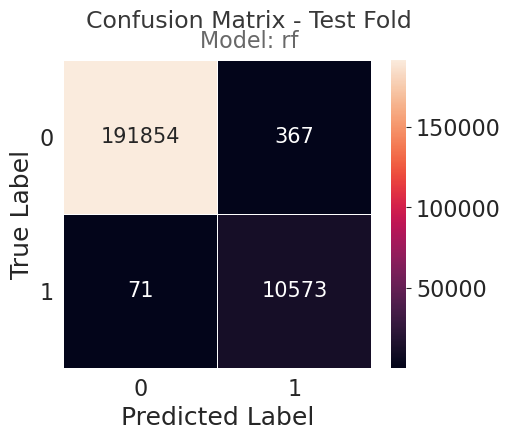

In [149]:
l_test_error = list()

for m_name, d_gs in d_search_fit.items():
    y_pred_ = d_gs.predict(X_train)
    y_true_ = y_train
    print(f"=== {m_name} ===")
    print(d_gs.best_estimator_)
#     try:
    print(classification_report(y_true_, y_pred=y_pred_, digits=3))
    accuracy_ = accuracy_score(y_true_, y_pred=y_pred_)
        
#     except ValueError:
#         y_pred_ = le.inverse_transform(y_pred_)
#         print(classification_report(y_test, y_pred=y_pred_, labels=le.classes_, digits=3))
#         accuracy_ = accuracy_score(y_test, y_pred=y_pred_)
        
    # save error dataframe
    l_test_error.append(
        {
            'model_name': m_name,
            'error': 1 - accuracy_,
            'accuracy': accuracy_,
            'model_class': str(type(d_gs.best_estimator_['clf'])).split('.')[-1][:-2],
            'model_params': str(d_gs.best_estimator_['clf']).replace('\n', ' '),
        }
    )
    
    # confusion matrix
    conf_mx = confusion_matrix(y_true=y_true_, y_pred=y_pred_, labels=le.classes_)
    mask_exclude = conf_mx == 0
    with sns.axes_style("white"):
        plt.figure(figsize=(5, 4))

        ax = sns.heatmap(
            conf_mx,
            # center=0,
            # cmap=cm.PiYG,
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            annot=True,
            annot_kws={"size": 15},
            mask=mask_exclude,
            square=True,
            fmt="0.0f",
            linewidths=.5,
        )
        plt.yticks(rotation=0)
        # plt.xticks(rotation=45)
        ax.set(
            ylabel='True Label',
            xlabel='Predicted Label',
        )

        plt.figtext(
            .5, .96, f"Confusion Matrix - Test Fold",
            fontsize=17, color='#383838', ha='center'
        );
        plt.figtext(
            .5, .91, f"Model: {m_name}",
            fontsize=16, color='#686868', ha='center'
        )
        plt.show()


=== rf ===
              precision    recall  f1-score   support

           0      0.950     0.994     0.972     48135
           1      0.230     0.034     0.059      2582

    accuracy                          0.945     50717
   macro avg      0.590     0.514     0.516     50717
weighted avg      0.914     0.945     0.925     50717



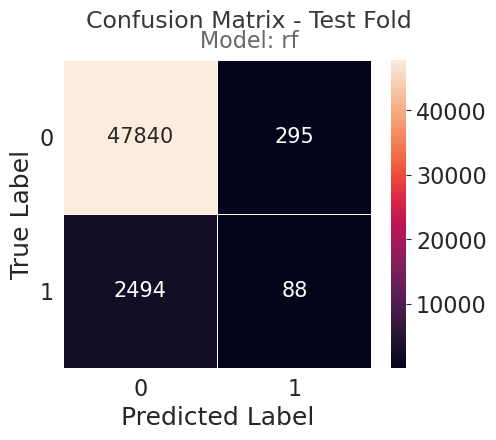

,pred-count,pred-percent,pred-pct_cumulative_sum
0,"50,334",99.2%,99.2%
1,383,0.8%,100.0%


In [152]:
l_test_error = list()

for m_name, d_gs in d_search_fit.items():
    y_pred_ = d_gs.predict(X_test)
    print(f"=== {m_name} ===")
#     try:
    print(classification_report(y_test, y_pred=y_pred_, digits=3))
    accuracy_ = accuracy_score(y_test, y_pred=y_pred_)
        
#     except ValueError:
#         y_pred_ = le.inverse_transform(y_pred_)
#         print(classification_report(y_test, y_pred=y_pred_, labels=le.classes_, digits=3))
#         accuracy_ = accuracy_score(y_test, y_pred=y_pred_)
        
    # save error dataframe
    l_test_error.append(
        {
            'model_name': m_name,
            'error': 1 - accuracy_,
            'accuracy': accuracy_,
            'model_class': str(type(d_gs.best_estimator_['clf'])).split('.')[-1][:-2],
            'model_params': str(d_gs.best_estimator_['clf']).replace('\n', ' '),
        }
    )
    
    # confusion matrix
    conf_mx = confusion_matrix(y_true=y_test, y_pred=y_pred_, labels=le.classes_)
    mask_exclude = conf_mx == 0
    with sns.axes_style("white"):
        plt.figure(figsize=(5, 4))

        ax = sns.heatmap(
            conf_mx,
            # center=0,
            # cmap=cm.PiYG,
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            annot=True,
            annot_kws={"size": 15},
            mask=mask_exclude,
            square=True,
            fmt="0.0f",
            linewidths=.5,
        )
        plt.yticks(rotation=0)
        # plt.xticks(rotation=45)
        ax.set(
            ylabel='True Label',
            xlabel='Predicted Label',
        )

        plt.figtext(
            .5, .96, f"Confusion Matrix - Test Fold",
            fontsize=17, color='#383838', ha='center'
        );
        plt.figtext(
            .5, .91, f"Model: {m_name}",
            fontsize=16, color='#686868', ha='center'
        )
        plt.show()
    display(
        value_counts_and_pcts(
            pd.Series(y_pred_, name='pred').to_frame(),
            'pred',
        )
    )

# Get feature importance

In [167]:
df_importances = (
    pd.DataFrame(
        {
            'feature_names': X_train.columns,
            'importances': d_search_fit['rf'].best_estimator_['clf'].feature_importances_,
            'std': np.std([tree.feature_importances_ for tree in d_search_fit['rf'].best_estimator_['clf'].estimators_], axis=0),
        }
    )
    .sort_values(by=['importances'], ascending=False)
)
df_importances.head(10)

,feature_names,importances,std
1,screen_view_count_14d,0.105415,0.053582
16,cosine_similarity,0.094628,0.018692
3,num_post_consumes_home,0.084224,0.023165
9,pct_post_consumes_nsfw,0.078295,0.010569
4,num_post_consumes_community,0.076290,0.013627
2,num_post_consumes,0.075354,0.012865
0,tos_sub_count,0.074675,0.015408
8,num_post_consumes_nsfw,0.066118,0.005561
7,num_post_consumes_android,0.061699,0.008636
10,view_and_consume_unique_count,0.037882,0.003391


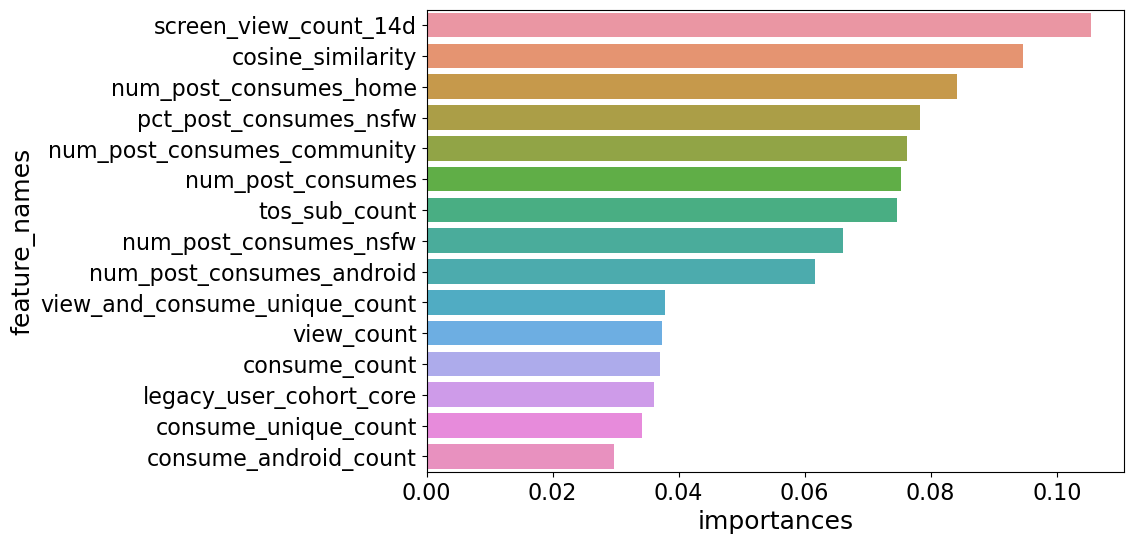

In [168]:
ax = sns.barplot(
    data=df_importances.head(15),
    x='importances',
    y='feature_names',
)

<BarContainer object of 15 artists>

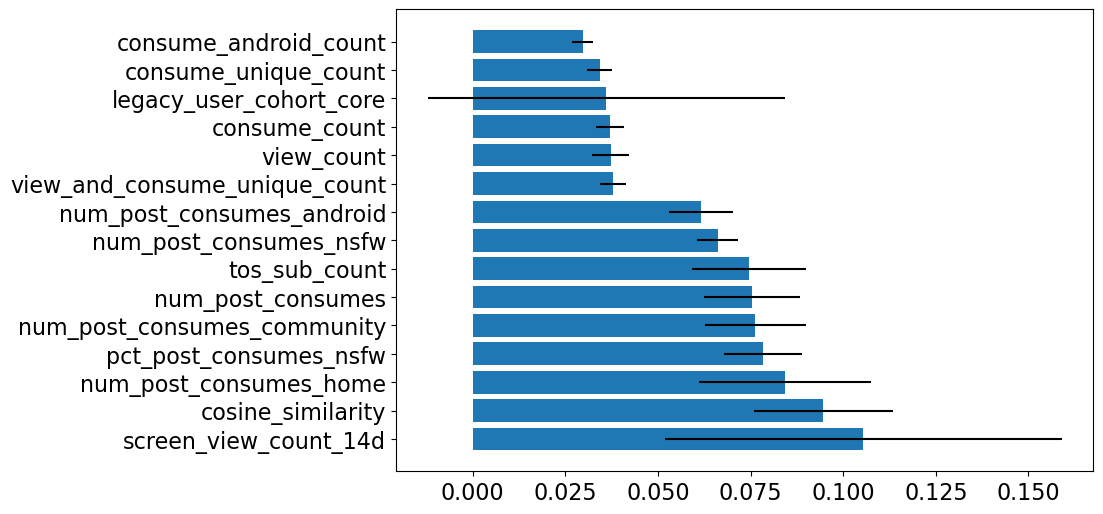

In [169]:
plt.barh(
    y=df_importances.head(15)['feature_names'],
    width=df_importances.head(15)['importances'],
    xerr=df_importances.head(15)['std'],
)

## Can we get a bette prediction by lowering the proba threshold?

In [155]:
d_search_fit['rf'].classes_

array([0, 1])

In [159]:
d_search_fit['rf'].predict_proba(X_test)[:, 1]

array([0.02398939, 0.16853243, 0.13001007, ..., 0.25203131, 0.1023329 ,
       0.40530864])

In [160]:
import plotly.figure_factory as ff

In [166]:
# group_labels = ['distplot'] # name of the dataset

# fig = ff.create_distplot(
#     [d_search_fit['rf'].predict_proba(X_test)[:, 1]],
#     group_labels
# )
# fig.show()

In [163]:
df_y_test = pd.DataFrame(
    {
        'y_test': y_test,
        'y_pred_proba': d_search_fit['rf'].predict_proba(X_test)[:, 1],
    }
)

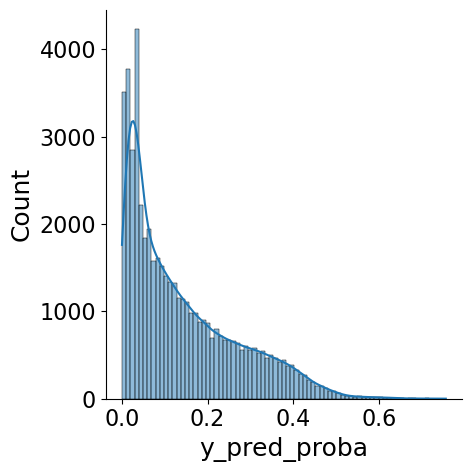

In [164]:
sns.displot(data=df_y_test, x="y_pred_proba", kde=True)


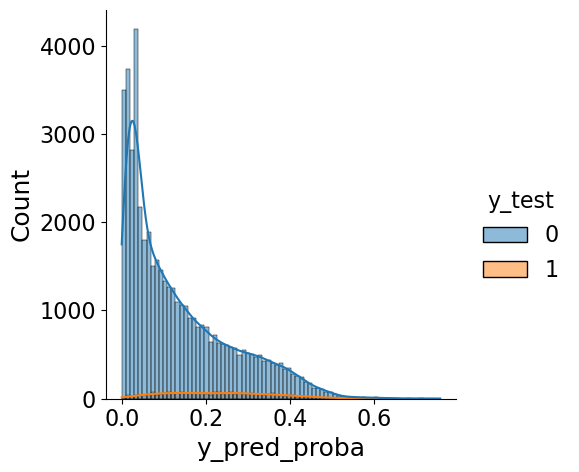

In [165]:
sns.displot(data=df_y_test, x="y_pred_proba", kde=True, hue='y_test')


In [ ]:
# fig = px.histogram(
#     df_y_test, x="y_pred_proba", y="y_test", color="sex",
#     marginal="box", # or violin, rug
#     hover_data=df.columns
# )
# fig.show()